In [14]:
import pandas as pd
import xarray as xr
from glob import glob
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
# from ../utils.cmod5n import cmod5n_forward, cmod5n_inverse

In [127]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")


In [133]:
fn_fullpath = f"{glob('../processed_data/Sentinel1/WV/2021/*.nc')[-1]}"
fn = fn_fullpath.split("\\")[-1]

ds = xr.open_dataset(fn_fullpath)

np.median(ds.incidence.values)

fn

'S1A_WV_SLC__1SSV_20211204T155812_20211204T160647_040861_04D9FC_F9F6__WV_017.nc'

In [134]:
df1[df1.renamed_filename == fn]

,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,prob_2,class_3,...,band1_abs_error_mean,band1_rel_error_mean,band1_rmse,band2_wspd_mean,band2_wspd_median,band2_error_mean,band2_error_median,band2_abs_error_mean,band2_rel_error_mean,band2_rmse
174,17,wv1,-146.181079922 42.271247523,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.996547,IB,0.002811,AF,...,18.071824,-0.998192,18.072377,0.011308,-0.039062,-18.093251,-18.143621,18.093251,-0.999375,18.093477


In [135]:
df2[df2.renamed_filename == fn]

,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,prob_2,class_3,...,sigma0_cmod_row_var,sigma0_cmod_column_var,sigma0_cmod_skew,sigma0_cmod_kurtosis,wspd_median,wspd_var,wspd_skewness,wspd_kurtosis,residual,residual_normalized


In [168]:
def compute_2d_fft(sigma0):
    """Compute 2D FFT of sigma0 values."""
    # Clean NaN values
    sigma0_clean = sigma0.copy()
    if np.isnan(sigma0_clean).any():
        sigma0_clean[np.isnan(sigma0_clean)] = 0
    
    fft_data = np.fft.fft2(sigma0_clean)
    psd_2d = np.abs(fft_data)**2
    
    freqx = np.fft.fftfreq(sigma0.shape[1])
    freqy = np.fft.fftfreq(sigma0.shape[0])
    kx, ky = np.meshgrid(freqx, freqy)
    kmagnitude = np.sqrt(kx**2 + ky**2)
    
    return fft_data, psd_2d, kx, ky, kmagnitude, sigma0_clean


def plot_sigma0(sigma0, title="Sigma0"):
    """Plot the sigma0 values."""
    plt.figure(figsize=(10, 8))
    plt.imshow(sigma0, cmap='gray', aspect='auto')
    plt.colorbar(label='Sigma0')
    plt.title(f"{title}")
    plt.xlabel('Range Pixel')
    plt.ylabel('Azimuth Pixel')
    plt.show()

def plot_psd(psd_2d, title="2D Power Spectral Density"):
    """Plot the 2D Power Spectral Density."""
    plt.figure(figsize=(10, 8))
    plt.imshow(np.log(psd_2d), cmap='gray', aspect='auto')
    plt.colorbar(label='Log Power Spectral Density')
    plt.title(title)
    plt.xlabel('kx [1/m]')
    plt.ylabel('ky [1/m]')
    plt.show()
    
def band_filter(fft_data, kmagnitude, kmin, kmax):
    """Apply band-pass filter to FFT data."""
    # Create mask for band-pass filter
    mask = (kmagnitude >= kmin) & (kmagnitude < kmax)
    
    # Apply filter in frequency domain
    fft_filtered = np.zeros_like(fft_data, dtype=complex)
    fft_filtered[mask] = fft_data[mask]
    
    # Invert back to spatial domain
    filtered_sigma0 = np.real(np.fft.ifft2(fft_filtered))
    
    return filtered_sigma0


In [169]:
fn_fullpath = f"{glob('../processed_data/Sentinel1/WV/2021/*.nc')[-1]}"
fn = fn_fullpath.split("\\")[-1]

ds = xr.open_dataset(fn_fullpath)

np.median(ds.incidence.values)

_, psd, _, _, _, sigma0_clean = compute_2d_fft(ds.sigma0.values[0])
start_date = ds.start_date[:-7]

fn_fullpath = fn_fullpath[3:].replace("\\", "/")
fn_fullpath

'processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1SSV_20211204T155812_20211204T160647_040861_04D9FC_F9F6__WV_017.nc'

In [170]:
row = dfwv1[dfwv1.sar_filepath == fn_fullpath]

# dfwv1.sar_filepath

In [174]:
v = np.array(row["era5_wspd"])
phi = np.array(row["era5_wdir"])
theta = ds.incidence.values
sigma_cmod = cmod5n_forward(v, phi, theta)
sigma_sar = sigma0_clean


fft_sar, psd_sar, kx_sar, ky_sar, kmag_sar, _ = compute_2d_fft(sigma_sar)
fft_cmod, psd_cmod, kx_cmod, ky_cmod, kmag_cmod, _ = compute_2d_fft(sigma_cmod)
        


In [175]:
band0a_cmod = band_filter(fft_cmod, kmag_cmod, 0, 0.0333)
band0b_cmod = band_filter(fft_cmod, kmag_cmod, 0.0333, 0.0666)
band0c_cmod = band_filter(fft_cmod, kmag_cmod, 0.0666, 0.1)
band1_cmod = band_filter(fft_cmod, kmag_cmod, 0.1, 0.3)
band2_cmod = band_filter(fft_cmod, kmag_cmod, 0.3, np.inf)

band0a_sar = band_filter(fft_sar, kmag_sar, 0, 0.0333)
band0b_sar = band_filter(fft_sar, kmag_sar, 0.0333, 0.0666)
band0c_sar = band_filter(fft_sar, kmag_sar, 0.0666, 0.1)
band1_sar = band_filter(fft_sar, kmag_sar, 0.1, 0.3)
band2_sar = band_filter(fft_sar, kmag_sar, 0.3, np.inf)

In [176]:
ratio_band0a = np.nanmean(band0a_cmod / np.where(band0a_sar == 0, np.nan, band0a_sar))
ratio_band0b = np.nanmean(band0b_cmod / np.where(band0b_sar == 0, np.nan, band0b_sar))
ratio_band0c = np.nanmean(band0c_cmod / np.where(band0c_sar == 0, np.nan, band0c_sar))
ratio_band1 = np.nanmean(band1_cmod / np.where(band1_sar == 0, np.nan, band1_sar))
ratio_band2 = np.nanmean(band2_cmod / np.where(band2_sar == 0, np.nan, band2_sar))

In [180]:
band0c_cmod

array([[ 0.00321309,  0.00867838,  0.01189353, ..., -0.0118309 ,
        -0.008575  , -0.00308633],
       [ 0.00324136,  0.00870928,  0.01192649, ..., -0.01181021,
        -0.00855223, -0.00306091],
       [ 0.00325767,  0.00872766,  0.01194642, ..., -0.0117998 ,
        -0.00854024, -0.00304684],
       ...,
       [ 0.00313583,  0.00859357,  0.01180288, ..., -0.01188649,
        -0.00863651, -0.00315542],
       [ 0.00315214,  0.00861195,  0.01182281, ..., -0.01187607,
        -0.00862453, -0.00314136],
       [ 0.00318041,  0.00864286,  0.01185577, ..., -0.01185539,
        -0.00860175, -0.00311594]])

In [183]:
dfwv1

,sar_filepath,era5_wspd,era5_wdir,wspd_perturbed,wdir_perturbed,phi_perturbed,phi_nominal,sigma_sar_median,sigma_cmod_median,errors_band0a,...,ratio_band2,coherence_metrics,sensitivity_metrics,errors_mix1,errors_mix2,errors_mix3,errors_mix4,kw_statistic,kw_p_value,is_scale_dependent
0,processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...,15.872389,251.150527,16.769125,249.482533,-32.440227,-30.772232,0.530829,0.525546,"{'abs_error': 1.117768733782777, 'bias': 1.070...",...,0.002167,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.020708996969222057, 'band0b': 7.7...","{'abs_error': 2.7395724818299807, 'bias': 0.88...","{'abs_error': 1.1347935562886053, 'bias': 1.06...","{'abs_error': 2.7149328546999305, 'bias': 0.88...","{'abs_error': 1.1889137484437717, 'bias': 1.07...",109265.134237,0.0,True
1,processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...,18.104559,257.966243,19.389358,256.452565,-25.365184,-23.851501,0.652915,0.645803,"{'abs_error': 1.661593960331196, 'bias': 1.595...",...,-0.102643,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.021669555796833058, 'band0b': -1....","{'abs_error': 3.981469484569905, 'bias': 1.704...","{'abs_error': 1.6661464279448184, 'bias': 1.59...","{'abs_error': 3.9640510861754037, 'bias': 1.70...","{'abs_error': 1.7317930391160152, 'bias': 1.61...",109578.101387,0.0,True
2,processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...,16.669525,82.010073,17.704843,80.397187,7.966920,9.579803,0.712883,0.744356,"{'abs_error': 1.002966310110251, 'bias': 0.891...",...,-0.047422,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.041500309302929715, 'band0b': 1.2...","{'abs_error': 4.537599618813043, 'bias': 1.912...","{'abs_error': 1.0830349800609897, 'bias': 0.89...","{'abs_error': 4.521665947102979, 'bias': 1.918...","{'abs_error': 1.1904400152474783, 'bias': 0.90...",112207.069602,0.0,True
3,processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...,16.263756,83.806840,17.228531,82.165903,9.198221,10.839157,0.714986,0.725240,"{'abs_error': 1.2806470023102303, 'bias': 1.22...",...,-0.042836,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.043516457785253114, 'band0b': -3....","{'abs_error': 3.8635230214521448, 'bias': 1.74...","{'abs_error': 1.2930035525459682, 'bias': 1.22...","{'abs_error': 3.8478131638142385, 'bias': 1.74...","{'abs_error': 1.3521669446958975, 'bias': 1.23...",112005.734171,0.0,True
4,processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...,17.090385,98.803959,18.198870,97.220168,27.919204,29.502991,0.662777,0.698000,"{'abs_error': 0.7353538270965738, 'bias': 0.56...",...,0.009404,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.04312683964218801, 'band0b': 8.47...","{'abs_error': 3.1365845403961057, 'bias': 1.83...","{'abs_error': 0.7815400634982975, 'bias': 0.56...","{'abs_error': 3.107537256123688, 'bias': 1.823...","{'abs_error': 0.8728758911780803, 'bias': 0.57...",110143.267661,0.0,True


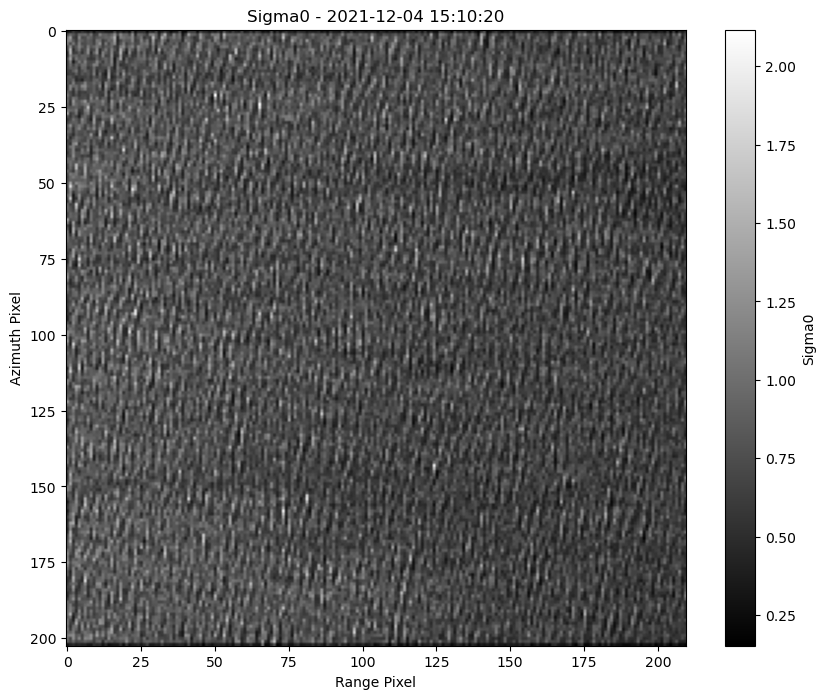

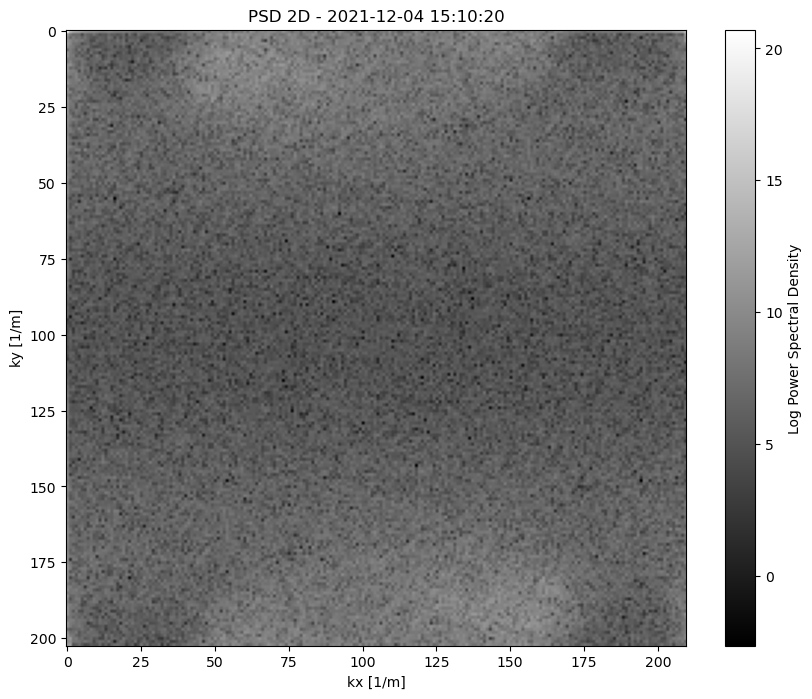

In [59]:
plot_sigma0(sigma0_clean, title=f"Sigma0 - {start_date}")
plot_psd(psd, title=f"PSD 2D - {start_date}")

In [187]:
import pandas as pd

dfwv1 = pd.read_parquet("../results_v2/wv1_results.parquet")
dfwv2 = pd.read_parquet("../results_v2/wv2_results.parquet")

In [212]:
def plot_ratios(df_results, wv, percentile_threshold=98):
    """
    Plot transfer function ratios with outlier handling.
    
    Parameters:
    -----------
    df_results : pandas.DataFrame
        DataFrame containing the analysis results
    wv : str
        Wave mode identifier (e.g., 'wv1', 'wv2')
    percentile_threshold : float
        Percentile threshold for outlier removal (e.g., 98 means keep values between 1st and 98th percentile)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    
    band_labels = ['Band 0a (k < 0.0333)', 'Band 0b (0.0333 ≤ k < 0.0666)', 
                   'Band 0c (0.0666 ≤ k < 0.1)', 'Band 1 (0.1 ≤ k < 0.3)', 
                   'Band 2 (k ≥ 0.3)']

    # Extract ratios
    ratio0a = df_results['ratio_band0a']
    ratio0b = df_results['ratio_band0b']
    ratio0c = df_results['ratio_band0c']
    ratio1 = df_results['ratio_band1']
    ratio2 = df_results['ratio_band2']
    
    # Store original ratios
    original_ratios = [ratio0a, ratio0b, ratio0c, ratio1, ratio2]
    
    # Clean extreme outliers using percentile thresholding
    cleaned_ratios = []
    
    for ratio in original_ratios:
        # Create a copy to avoid modifying the original data
        clean_ratio = ratio.copy()
        
        # Remove NaN values
        clean_ratio = clean_ratio.dropna()
        
        if len(clean_ratio) > 0:
            # Apply percentile thresholding for outlier removal
            lower_threshold = np.percentile(clean_ratio, 100 - percentile_threshold)
            upper_threshold = np.percentile(clean_ratio, percentile_threshold)
            
            # Filter outliers
            clean_ratio = clean_ratio[(clean_ratio >= lower_threshold) & 
                                      (clean_ratio <= upper_threshold)]
        
        cleaned_ratios.append(clean_ratio)
    
    # 1. Original plot with outliers (for reference)
    plt.figure(figsize=(12, 6))
    plt.boxplot(original_ratios, tick_labels=band_labels)
    plt.title(f'Transfer Function Ratios by Wavenumber Band ({wv.upper()}) - With Outliers')
    plt.ylabel('Model-to-Observed Ratio')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)  # Reference line at ratio=1
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../transfer_function_ratios_{wv}_with_outliers.png', dpi=300)
    plt.close()
    
    # 2. Cleaned plot without extreme outliers
    plt.figure(figsize=(12, 6))
    plt.boxplot(cleaned_ratios, tick_labels=band_labels)
    plt.title(f'Transfer Function Ratios by Wavenumber Band ({wv.upper()}) - Outliers Removed')
    plt.ylabel('Model-to-Observed Ratio')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)  # Reference line at ratio=1
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../transfer_function_ratios_{wv}_cleaned.png', dpi=300)
    plt.close()
    
    # 3. Tighter view focused on central tendencies
    plt.figure(figsize=(12, 6))
    plt.boxplot(cleaned_ratios, tick_labels=band_labels)
    plt.title(f'Transfer Function Ratios by Wavenumber Band ({wv.upper()}) - Tight View')
    plt.ylabel('Model-to-Observed Ratio')
    
    # Calculate appropriate y-axis limits based on data
    all_values = []
    for ratio in cleaned_ratios:
        all_values.extend(ratio.values)
    
    if len(all_values) > 0:
        q1 = np.percentile(all_values, 25)
        q3 = np.percentile(all_values, 75)
        iqr = q3 - q1
        y_min = max(0, q1 - 1.5 * iqr)  # Ensure non-negative minimum
        y_max = 2  # Cap at 2 for better focus on ratio=1 reference
        plt.ylim([y_min, y_max])
    
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)  # Reference line at ratio=1
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'../transfer_function_ratios_{wv}_tight_view.png', dpi=300)
    plt.close()
    
    # Print summary statistics for each band
    print(f"\nSummary Statistics for {wv.upper()} after Outlier Removal:")
    print("-" * 50)
    for i, (ratio, label) in enumerate(zip(cleaned_ratios, band_labels)):
        if len(ratio) > 0:
            print(f"{label}:")
            print(f"  Mean: {ratio.mean():.4f}")
            print(f"  Median: {ratio.median():.4f}")
            print(f"  Std Dev: {ratio.std():.4f}")
            print(f"  Count: {len(ratio)}")
            print(f"  Range: [{ratio.min():.4f}, {ratio.max():.4f}]")
            print()
    
    return cleaned_ratios

# Example usage:
cleaned_ratios_wv1 = plot_ratios(dfwv1, 'wv1', percentile_threshold=98)
cleaned_ratios_wv2 = plot_ratios(dfwv2, 'wv2', percentile_threshold=98)


Summary Statistics for WV1 after Outlier Removal:
--------------------------------------------------
Band 0a (k < 0.0333):
  Mean: 1.2232
  Median: 1.0396
  Std Dev: 0.9183
  Count: 35443
  Range: [0.8359, 8.9392]

Band 0b (0.0333 ≤ k < 0.0666):
  Mean: 0.1631
  Median: 0.1521
  Std Dev: 0.9400
  Count: 35443
  Range: [-4.5991, 5.1175]

Band 0c (0.0666 ≤ k < 0.1):
  Mean: 0.0674
  Median: 0.0658
  Std Dev: 0.6075
  Count: 35443
  Range: [-3.1472, 3.0780]

Band 1 (0.1 ≤ k < 0.3):
  Mean: 0.0079
  Median: 0.0062
  Std Dev: 0.1635
  Count: 35443
  Range: [-0.8590, 0.8653]

Band 2 (k ≥ 0.3):
  Mean: 0.0017
  Median: 0.0008
  Std Dev: 0.0538
  Count: 35443
  Range: [-0.2922, 0.3123]


Summary Statistics for WV2 after Outlier Removal:
--------------------------------------------------
Band 0a (k < 0.0333):
  Mean: 1.2057
  Median: 1.1688
  Std Dev: 0.3551
  Count: 35515
  Range: [0.7415, 3.5849]

Band 0b (0.0333 ≤ k < 0.0666):
  Mean: 0.0298
  Median: 0.0329
  Std Dev: 0.4991
  Count: 35515

In [190]:
plot_ratios(dfwv1, 'wv1')

C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_12768\2174912982.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ratio0a, ratio0b, ratio0c, ratio1, ratio2], labels=band_labels)


In [191]:
plot_ratios(dfwv2, 'wv2')

C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_12768\2174912982.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ratio0a, ratio0b, ratio0c, ratio1, ratio2], labels=band_labels)


In [194]:
def plot_sensitivity(df_results, wv):
        
        band_labels = ['Band 0a (k < 0.0333)', 'Band 0b (0.0333 ≤ k < 0.0666)', 
                    'Band 0c (0.0666 ≤ k < 0.1)', 'Band 1 (0.1 ≤ k < 0.3)', 
                    'Band 2 (k ≥ 0.3)']
        
        # 2. Scale-Dependent Sensitivity
        sensitivity0a = df_results['sensitivity_metrics'].apply(lambda x: x['band0a'])
        sensitivity0b = df_results['sensitivity_metrics'].apply(lambda x: x['band0b'])
        sensitivity0c = df_results['sensitivity_metrics'].apply(lambda x: x['band0c'])
        sensitivity1 = df_results['sensitivity_metrics'].apply(lambda x: x['band1'])
        sensitivity2 = df_results['sensitivity_metrics'].apply(lambda x: x['band2'])
        
        plt.figure(figsize=(12, 6))
        plt.boxplot([sensitivity0a, sensitivity0b, sensitivity0c, sensitivity1, sensitivity2], labels=band_labels)
        plt.title(f'Scale-Dependent Sensitivity by Wavenumber Band {wv.upper()}')
        plt.ylabel('Sensitivity (∆sigma0/∆wspd)')
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'../scale_sensitivity_{wv}.png', dpi=300)
        plt.close()

In [195]:
plot_sensitivity(dfwv1, 'wv1')
plot_sensitivity(dfwv2, 'wv2')

C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_12768\131852257.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sensitivity0a, sensitivity0b, sensitivity0c, sensitivity1, sensitivity2], labels=band_labels)
C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_12768\131852257.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sensitivity0a, sensitivity0b, sensitivity0c, sensitivity1, sensitivity2], labels=band_labels)


In [196]:
def plot_cross_scale_analysis(df_results, wv):
        band_labels = ['Band 0a (k < 0.0333)', 'Band 0b (0.0333 ≤ k < 0.0666)', 
                    'Band 0c (0.0666 ≤ k < 0.1)', 'Band 1 (0.1 ≤ k < 0.3)', 
                    'Band 2 (k ≥ 0.3)']
        
        bias0a = df_results['errors_band0a'].apply(lambda x: x['bias'])
        bias0b = df_results['errors_band0b'].apply(lambda x: x['bias'])
        bias0c = df_results['errors_band0c'].apply(lambda x: x['bias'])
        bias1 = df_results['errors_band1'].apply(lambda x: x['bias'])
        bias2 = df_results['errors_band2'].apply(lambda x: x['bias'])
        
        mix1_bias = df_results['errors_mix1'].apply(lambda x: x['bias'])
        mix2_bias = df_results['errors_mix2'].apply(lambda x: x['bias'])
        mix3_bias = df_results['errors_mix3'].apply(lambda x: x['bias'])
        mix4_bias = df_results['errors_mix4'].apply(lambda x: x['bias'])
        
        plt.figure(figsize=(14, 8))
        mix_labels = ['Model(0a,0b)+Obs(0c,1,2)', 'Obs(0a,0b)+Model(0c,1,2)',
                    'Model(0a,0b,0c)+Obs(1,2)', 'Obs(0a,0b,0c)+Model(1,2)']
        all_labels = [*band_labels, *mix_labels]
        
        plt.boxplot([bias0a, bias0b, bias0c, bias1, bias2, mix1_bias, mix2_bias, mix3_bias, mix4_bias], 
                    labels=all_labels)
        plt.title(f'Cross-Scale Impact Analysis {wv.upper()}: Bias')
        plt.ylabel('Bias (m/s)')
        plt.grid(alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'../cross_scale_impact_{wv}.png', dpi=300)
        plt.close()

In [197]:
plot_cross_scale_analysis(dfwv1, 'wv1')
plot_cross_scale_analysis(dfwv2, 'wv2')

C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_12768\398192707.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bias0a, bias0b, bias0c, bias1, bias2, mix1_bias, mix2_bias, mix3_bias, mix4_bias],
C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_12768\398192707.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bias0a, bias0b, bias0c, bias1, bias2, mix1_bias, mix2_bias, mix3_bias, mix4_bias],


In [ ]:
dfwv1.

,sar_filepath,era5_wspd,era5_wdir,wspd_perturbed,wdir_perturbed,phi_perturbed,phi_nominal,wspd_perturbed_strong,wdir_perturbed_strong,phi_perturbed_strong,...,ratio_band2,coherence_metrics,sensitivity_metrics,errors_mix1,errors_mix2,errors_mix3,errors_mix4,kw_statistic,kw_p_value,is_scale_dependent
0,/projects/fluxsar/data/Sentinel1/WV/2021/S1A_W...,16.263756,83.806840,17.228531,82.165903,9.198221,10.839157,18.193306,80.524965,7.557283,...,-0.042836,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.04351645778525313, 'band0b': -1.5...","{'abs_error': 3.8635230214521448, 'bias': 1.74...","{'abs_error': 1.2930035525459682, 'bias': 1.22...","{'abs_error': 3.8478131638142385, 'bias': 1.74...","{'abs_error': 1.3521669446958975, 'bias': 1.23...",112005.734171,0.0,True
1,/projects/fluxsar/data/Sentinel1/WV/2021/S1A_W...,15.088510,90.745164,15.848969,89.022980,161.294586,163.016785,16.609428,87.300795,159.572401,...,0.012115,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.02952295906736402, 'band0b': -4.0...","{'abs_error': 2.1458367503568962, 'bias': 0.95...","{'abs_error': 2.0107915359659216, 'bias': -2.0...","{'abs_error': 2.1168223061938756, 'bias': 0.94...","{'abs_error': 2.01562889776652, 'bias': -1.999...",113825.605157,0.0,True
2,/projects/fluxsar/data/Sentinel1/WV/2021/S1A_W...,15.749448,84.491347,16.624811,82.814854,154.014043,155.690552,17.500173,81.138362,152.337550,...,-0.005090,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.02306814412246988, 'band0b': 2.09...","{'abs_error': 3.780641861848802, 'bias': 1.498...","{'abs_error': 2.912949771675766, 'bias': -2.90...","{'abs_error': 3.7601877118765614, 'bias': 1.49...","{'abs_error': 2.926205183816045, 'bias': -2.89...",113878.863106,0.0,True
3,/projects/fluxsar/data/Sentinel1/WV/2021/S1A_W...,20.117805,218.462167,21.752606,217.087668,138.668784,140.043274,23.387408,215.713169,137.294285,...,-0.014993,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.011286787345286056, 'band0b': -9....","{'abs_error': 4.782525640694503, 'bias': 1.355...","{'abs_error': 1.4030727161955334, 'bias': -1.2...","{'abs_error': 4.777156255560338, 'bias': 1.373...","{'abs_error': 1.5271471227340132, 'bias': -1.2...",110075.517306,0.0,True
4,/projects/fluxsar/data/Sentinel1/WV/2021/S1A_W...,15.486546,63.424148,16.316203,61.729480,-11.486737,-9.792068,17.145860,60.034812,-13.181405,...,0.010952,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.035060328624098004, 'band0b': -3....","{'abs_error': 4.078659098868458, 'bias': 1.376...","{'abs_error': 0.9547425011786894, 'bias': -0.4...","{'abs_error': 4.067657954502593, 'bias': 1.376...","{'abs_error': 1.0308152314238568, 'bias': -0.4...",111910.732273,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36916,/projects/fluxsar/data/Sentinel1/WV/2020/S1A_W...,16.626520,81.083606,17.654362,79.467747,144.298924,145.914795,18.682203,77.851888,142.683065,...,0.065001,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.016832206186414487, 'band0b': 9.3...","{'abs_error': 4.983921758274836, 'bias': 1.569...","{'abs_error': 1.6243388249960244, 'bias': -0.6...","{'abs_error': 4.971635491662691, 'bias': 1.576...","{'abs_error': 1.6997019260432993, 'bias': -0.6...",115880.672535,0.0,True
36917,/projects/fluxsar/data/Sentinel1/WV/2020/S1A_W...,16.519564,74.529450,17.528811,72.906197,136.767709,138.390961,18.538059,71.282944,135.144456,...,0.016303,"{'band0a': 1.0, 'band0b': 1.0, 'band0c': 1.0, ...","{'band0a': 0.014405625359906568, 'band0b': 1.3...","{'abs_error': 3.847662726278877, 'bias': 1.264...","{'abs_error': 1.6353639491657495, 'bias': -1.2...","{'abs_error': 3.8062683731894023, 'bias': 1.25...","{'abs_error': 1.7252767625825078, 'bias': -1.2...",114193.942129,0.0,True
36918,/projects/fluxsar/data/Sentinel1/WV/2020/S1A_W...,18.049550,73.170417,19.324785,71.652936,138.285687,139.803162,20.600021,70.135454,136.768205,...,